In [2]:
def plot_histogram(list_info):
        
    %pylab inline

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.ticker import FuncFormatter
      
    x = np.arange(len(list_info))
    values = list_info
    labels = []
        
    plt.xticks( x+0.5,  (labels), rotation='vertical')
    plt.bar(x, values)
    plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
    plt.show()
    

In [3]:
def plot_histogram_counter(counter_info):
        
    %pylab inline

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.ticker import FuncFormatter
      
    x = np.arange(len(counter_info))
    values = []
    labels = []

    for c in counter_info:
        values.append(counter_info[c])
        
    values=sorted(values, reverse=True)
    plt.xticks( x+0.5,  (labels), rotation='vertical')
    plt.bar(x, values)
    plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
    plt.show()

In [4]:
def plot_cake_distribution(counter_info):
    %pylab inline
          
    import numpy as np
    import matplotlib.pyplot as plt
    from random import shuffle
    from collections import Counter
          
    fig = plt.figure(figsize=(10, 10), dpi=100)
         
    slices = [1,2,3] * 4 + [20, 25, 30] * 2
    shuffle(slices)
    cmap = plt.cm.prism
    colors = cmap(np.linspace(0., 1., len(slices)))
      
    labels = []
    values = []
      
    for c in counter_info:
        labels.append(c.rsplit('#', 1)[1])
        values.append(counter_info[c])
      
    plt.pie(values, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=1.5, labeldistance=1.6)
      
    plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
    plt.axis('equal')
      
    plt.show()

In [5]:
import rdflib

g=rdflib.Graph()
g.parse('lov17Jan.n3', format='n3')
#g.parse('lov7Oct.nq', format='nquads')
print("graph has %s statements." % len(g))

graph has 65473 statements.


# Understanding Linked Data via Learning Object Vocabularies (LOV)

## Background

The Linked Open Vocabularies (LOV) is a dataset of the vocabularies used in the Cloud of Linked Data.
The description of the datasets, their relations and usage are described using the <a href="http://lov.okfn.org/vocab/voaf/v2.3/index.html">Vocabulary of a Friend</a> (VOAF).

There is a <a href="http://lov.okfn.org/endpoint/lov">SPARQL endpoint</a> available for querying LOV.

## Data gathering and preparation

The dataset can be <a href="http://lov.okfn.org/dataset/lov/about/#lovdataset">downloaded from the LOV webpage</a>.

Graph analysis of VOAF relations. Examples of graph analysis techniques are <a href="http://networkx.github.io/documentation/latest/tutorial/tutorial.html#analyzing-graphs">here</a>.

In [6]:
from rdflib.namespace import RDF
import csv
from collections import Counter
import pandas as pd
import networkx as nx
import numpy as np
import sonnet as sn

datasets_list = []
general_graph =nx.DiGraph()

file_out = open('lov_nsa.csv', 'wb')
csv_w = csv.writer(file_out, delimiter='\t')
header=["Datasets","GraphNodes","Centrality","NumberComponent","NodesByComponent"]
csv_w.writerow(header)

voaf = rdflib.Namespace("http://purl.org/vocommons/voaf#")
voaf_props=['reliesOn','usedBy','metadataVoc','extends','specializes','generalizes','hasEquivalencesWith','hasDisjunctionsWith','similar']

for voaf_prop in voaf_props:
    print "*************************************************"
    line=[]
    # Take the metadataVoc subgraph:
    mv = rdflib.Graph()
    print "Analyzing "+voaf_prop
    
    if voaf_prop in 'reliesOn':
        mv += g.triples( (None, voaf.reliesOn, None) )
    elif voaf_prop in 'usedBy':
        mv += g.triples( (None, voaf.usedBy, None) )
    elif voaf_prop in 'metadataVoc':
        mv += g.triples( (None, voaf.metadataVoc, None) )
    elif voaf_prop in 'extends':
        mv += g.triples( (None, voaf.extends, None) )
    elif voaf_prop in 'specializes':
        mv += g.triples( (None, voaf.specializes, None) )
    elif voaf_prop in 'generalizes':
        mv += g.triples( (None, voaf.generalizes, None) )
    elif voaf_prop in 'hasEquivalencesWith':
        mv += g.triples( (None, voaf.hasEquivalencesWith, None) )
    elif voaf_prop in 'hasDisjunctionsWith':
        mv += g.triples( (None, voaf.hasDisjunctionsWith, None) )
    elif voaf_prop in 'similar':
        mv += g.triples( (None, voaf.similar, None) )
   

    # Represent as a NetworkX graph
    import networkx as nx
    import matplotlib as mp
    G=nx.DiGraph()
    
    dataset_list=[]
 
    for (s, p, o) in mv:
        dataset_list.append(str(s.encode('utf-8')))
        dataset_list.append(str(o))
        G.add_node(s)
        G.add_node(o)
        G.add_edge(s,o)
        general_graph.add_node(s)
        general_graph.add_node(o)
        general_graph.add_edge(s,o)
    
    dataset_list=sorted(set(dataset_list))
    datasets_list+=dataset_list
        
    print "Number of vocabularies found " + str(len(dataset_list))
    line.append(dataset_list)
    print "The graph has " + str(len(G)) + " nodes"
    line.append(len(G))
    print "The graph is composed"
    
    if len(G)==0:
        line+="0\t0\t0"
        csv_w.writerow(line)
    else:
        # Compute SNA measures
        centrality = nx.degree_centrality(G)

        #print centrality
        print "The degree centrality is " + str(centrality[max(centrality)])

        line.append(centrality[max(centrality)])
        
        centrality = nx.closeness_centrality(G)
        
        print "The closeness centrality is " + str(centrality[max(centrality)])

        line.append(centrality[max(centrality)])
        
        centrality = nx.betweenness_centrality(G)
        
        print "The betweenness centrality is " 
        print "{:10.20f}".format(centrality[max(centrality)])

        line.append(centrality[max(centrality)])

        # Component analysis:
        components = nx.connected_components(G.to_undirected())
        components = list(components)
        comps = len(components)
        #print comps
        print("There are "+ str(len(components))+" connected components.")
        line.append(len(components))

        count=0
        comp_nodes=[]
        while count < len(components):
            print "Component " + str(count+1)+ " has " +str(len(components[count]))
            comp_nodes+=str(len(components[count]))
            count+=1
        comp_nodes[:-1]
        line.append(comp_nodes)

        # Write to Pajek format (to check the graph with Gephi or other environments)
        print "Creating "+str(voaf_prop)+"_graph.net file."
        file_name=str(voaf_prop)+"_graph.net"
        nx.write_pajek(G, file_name)
        csv_w.writerow(line)
        
file_name="general_graph.net"
nx.write_pajek(general_graph, file_name)

*************************************************
Analyzing reliesOn
Number of vocabularies found 0
The graph has 0 nodes
The graph is composed
*************************************************
Analyzing usedBy
Number of vocabularies found 0
The graph has 0 nodes
The graph is composed
*************************************************
Analyzing metadataVoc
Number of vocabularies found 1329
The graph has 1329 nodes
The graph is composed
The degree centrality is 0.00451807228916
The closeness centrality is 0.0
The betweenness centrality is 
0.00000000000000000000
There are 1 connected components.
Component 1 has 1329
Creating metadataVoc_graph.net file.
*************************************************
Analyzing extends
Number of vocabularies found 1182
The graph has 1182 nodes
The graph is composed
The degree centrality is 0.00169348010161
The closeness centrality is 0.0
The betweenness centrality is 
0.00000000000000000000
There are 20 connected components.
Component 1 has 1102
Componen

In [7]:
print "---------------------------------------------"
print "------------Overall statistics---------------"
print "---------------------------------------------"

general_graph=general_graph.to_undirected()

vocs_list=[]
vann = rdflib.Namespace("http://purl.org/vocab/vann/")
voc_graph = rdflib.Graph()

voc_graph += g.triples( (None, vann.preferredNamespacePrefix, None) )


for (s, p, o) in voc_graph:
    vocs_list.append(str(s.encode('utf-8')))
    
vocs_list=sorted(set(vocs_list))
print "Number of vocabularies"
print len(vocs_list)

print "----------------------------------------------------"
print "Degree list"
degree_nodes_list=Counter(general_graph.degree().values())
print degree_nodes_list

num_nodes=[]
degrees=[]
for degree_nodes in degree_nodes_list:
    num_nodes.append(degree_nodes_list[degree_nodes])
    degrees.append(degree_nodes)
print "----------------------------------------------------"
print "Num nodes"
print num_nodes
print "Degrees"
print degrees


import powerlaw

data = num_nodes
results = powerlaw.Fit(data)
print "Alpha value nodes is"
print results.power_law.alpha
print "Xmin value nodes is"
print results.power_law.xmin
data = degrees
results = powerlaw.Fit(data)
print "Alpha value degrees is"
print results.power_law.alpha
print "Xmin value degrees is"
print results.power_law.xmin

density = nx.density(general_graph)
print "----------------------------------------------------"
print "The density of LOV is " + str(density)

clustering =  nx.average_clustering(general_graph)
print "----------------------------------------------------"
print "The clustering of LOV is " + str(clustering)

num_comp = nx.number_connected_components(general_graph)
print "----------------------------------------------------"
print "The number of connected components in LOV is " + str(num_comp)

components = nx.connected_components(general_graph)
components = list(components)

count=0
comp_nodes=[]
while count < num_comp:
    print "Component " + str(count+1)+ " has " +str(len(components[count]))
    comp_nodes+=str(len(components[count]))
    count+=1

file_name="general_graph.net"
nx.write_pajek(general_graph, file_name)

---------------------------------------------
------------Overall statistics---------------
---------------------------------------------
Number of vocabularies
589
----------------------------------------------------
Degree list
Counter({1: 302, 7: 169, 8: 162, 3: 159, 5: 159, 6: 156, 2: 148, 4: 142, 9: 137, 10: 104, 11: 55, 12: 51, 14: 33, 13: 31, 15: 18, 16: 12, 18: 12, 23: 6, 17: 5, 20: 4, 19: 3, 21: 3, 24: 2, 26: 2, 29: 2, 42: 2, 52: 2, 63: 2, 27: 1, 30: 1, 31: 1, 32: 1, 33: 1, 1190: 1, 40: 1, 45: 1, 46: 1, 47: 1, 648: 1, 179: 1, 53: 1, 54: 1, 570: 1, 1211: 1, 62: 1, 450: 1, 68: 1, 161: 1, 72: 1, 781: 1, 976: 1, 81: 1, 83: 1, 66: 1, 335: 1, 446: 1})
----------------------------------------------------
Num nodes
[302, 148, 159, 142, 159, 156, 169, 162, 137, 104, 55, 51, 31, 33, 18, 12, 5, 12, 3, 4, 3, 6, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Degrees
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Alpha value nodes is
1.66267142318
Xmin value nodes is
1.0
Alpha value degrees is
1.64805940307
Xmin value degrees is
16.0
----------------------------------------------------
The density of LOV is 0.00536930035808
----------------------------------------------------
The clustering of LOV is 0.0
----------------------------------------------------
The number of connected components in LOV is 1
Component 1 has 1911


In [8]:
langs_list=[]
dcterms = rdflib.Namespace("http://purl.org/dc/terms/")
lang_graph = rdflib.Graph()

lang_graph += g.triples( (None, dcterms.language, None) )

for (s, p, o) in lang_graph:
    langs_list.append(str(o))
    G.add_node(s)
    G.add_node(o)
    G.add_edge(s,o)

nx.write_pajek(G, "lov_file.net")
   
print "----------------------------------------------------"    
print "Number of different languages " + str(len(sorted(set(langs_list))))
print "Top used languages"
print Counter(langs_list)
data=[419,42,28,21,20,12,8,7,6,6,5,5,5,5,4,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
results = powerlaw.Fit(data)
print "Alpha value is"
print results.power_law.alpha
print "Xmin value is"
print results.power_law.xmin

print "----------------------------------------------------"
print "Five top used languages in %"
for lang in Counter(langs_list).most_common(5):
    perc_lang=(lang[1]*100)/len(vocs_list)
    print lang[0][-3:] +" "+ str(perc_lang) + "%"


num_langs_list=[]
vocs_name_list=[]
vocs_bad=[]

for voc in vocs_list:
    langs_list = []
    lang_graph += g.triples( (None, dcterms.language, None) )
    num_lang=0
    for (s, p, o) in lang_graph:
        if voc in str(s.encode('utf-8')):
            num_lang+=1
    if num_lang==0:
        vocs_bad.append(voc)
    vocs_name_list.append(voc)
    num_langs_list.append(num_lang)

print "----------------------------------------------------"
print "Languages by vocabularies"
lang_df=pd.DataFrame({'vocabulary': vocs_name_list, 'languages': num_langs_list})
print lang_df.sort(['languages'], ascending=[0])
lang_df_sort=lang_df.sort(['languages'], ascending=[0])

print "List of language occurrences"
print lang_df_sort[['languages']].values.tolist()
data = lang_df_sort[['languages']].values.tolist()
results = powerlaw.Fit(data)
print "Alpha value is"
print results.power_law.alpha
print "Xmin value is"
print results.power_law.xmin


print "IQR langs" 
iqr=np.percentile(num_langs_list, 75) - np.percentile(num_langs_list, 25)
print iqr

print "----------------------------------------------------"
print "Vocs without languages"
print vocs_bad
print len(vocs_bad)

----------------------------------------------------
Number of different languages 51
Top used languages
Counter({'http://id.loc.gov/vocabulary/iso639-2/eng': 1334, 'http://id.loc.gov/vocabulary/iso639-2/fra': 164, 'http://id.loc.gov/vocabulary/iso639-2/spa': 110, 'http://id.loc.gov/vocabulary/iso639-2/deu': 97, 'http://id.loc.gov/vocabulary/iso639-2/ita': 96, 'http://id.loc.gov/vocabulary/iso639-2/rus': 44, 'http://id.loc.gov/vocabulary/iso639-2/jpn': 43, 'http://id.loc.gov/vocabulary/iso639-2/por': 41, 'http://id.loc.gov/vocabulary/iso639-2/nld': 39, 'http://id.loc.gov/vocabulary/iso639-2/pol': 34, 'http://id.loc.gov/vocabulary/iso639-2/zho': 29, 'http://id.loc.gov/vocabulary/iso639-2/nor': 28, 'http://id.loc.gov/vocabulary/iso639-2/swe': 26, 'http://id.loc.gov/vocabulary/iso639-2/ces': 26, 'http://id.loc.gov/vocabulary/iso639-2/fin': 23, 'http://id.loc.gov/vocabulary/iso639-2/ara': 23, 'http://id.loc.gov/vocabulary/iso639-2/tur': 20, 'http://id.loc.gov/vocabulary/iso639-2/kor': 19, 

Calculating best minimal value for power law fit


----------------------------------------------------
Languages by vocabularies


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


     languages                                         vocabulary
96          41                  http://linkedgeodata.org/ontology
50          29                       http://dbpedia.org/ontology/
329         18  http://rdf.muninn-project.org/ontologies/military
461         15                    http://www.lingvoj.org/ontology
332          8                              http://rdfs.co/bevon/
579          7                             https://w3id.org/seas/
544          6                          http://www.w3.org/ns/dcat
1            6           http://aims.fao.org/aos/geopolitical.owl
87           6                       http://lemon-model.net/lemon
431          6                http://www.cidoc-crm.org/cidoc-crm/
75           6        http://idi.fundacionctic.org/cruzar/turismo
386          6                      http://usefulinc.com/ns/doap#
122          5          http://ns.inria.fr/nicetag/2010/09/09/voc
436          5  http://www.ebu.ch/metadata/ontologies/ebucore/...
388       

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
Values less than or equal to 0 in data. Throwing out 0 or negative values


Alpha value is
3.579236791
Xmin value is
5.0
IQR langs
1.0
----------------------------------------------------
Vocs without languages
['http://archivi.ibc.regione.emilia-romagna.it/ontology/eac-cpf/', 'http://bibframe.org/vocab', 'http://data.lirmm.fr/ontologies/food', 'http://data.lirmm.fr/ontologies/oan', 'http://data.lirmm.fr/ontologies/osp', 'http://data.lirmm.fr/ontologies/passim', 'http://data.lirmm.fr/ontologies/vdpp', 'http://data.ordnancesurvey.co.uk/ontology/50kGazetteer/', 'http://data.ordnancesurvey.co.uk/ontology/geometry/', 'http://data.semanticweb.org/ns/swc/ontology', 'http://data.totl.net/game/', 'http://def.seegrid.csiro.au/isotc211/iso19107/2003/geometry', 'http://def.seegrid.csiro.au/isotc211/iso19108/2002/temporal', 'http://def.seegrid.csiro.au/isotc211/iso19109/2005/feature', 'http://def.seegrid.csiro.au/isotc211/iso19115/2003/dataquality', 'http://def.seegrid.csiro.au/isotc211/iso19115/2003/lineage', 'http://def.seegrid.csiro.au/isotc211/iso19150/-2/2012/basic',

Calculating best minimal value for power law fit


/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


----------------------------------------------------
      classes                                         vocabulary
564      2853  http://lov.okfn.org/dataset/lov/vocabs/obo/ver...
531      1592  http://lov.okfn.org/dataset/lov/vocabs/dicom/v...
507      1592  http://lov.okfn.org/dataset/lov/vocabs/dicom/v...
1183     1521  http://lov.okfn.org/dataset/lov/vocabs/sio/ver...
504      1471  http://lov.okfn.org/dataset/lov/vocabs/sio/ver...
354      1469  http://lov.okfn.org/dataset/lov/vocabs/acm/ver...
1205     1428  http://lov.okfn.org/dataset/lov/vocabs/sio/ver...
628      1414  http://lov.okfn.org/dataset/lov/vocabs/sio/ver...
156      1414  http://lov.okfn.org/dataset/lov/vocabs/sio/ver...
7        1414  http://lov.okfn.org/dataset/lov/vocabs/sio/ver...
515      1413  http://lov.okfn.org/dataset/lov/vocabs/sio/ver...
622      1397  http://lov.okfn.org/dataset/lov/vocabs/sio/ver...
845      1396  http://lov.okfn.org/dataset/lov/vocabs/sio/ver...
160      1293  http://lov.okfn.org/da

`%matplotlib` prevents importing * from pylab and numpy


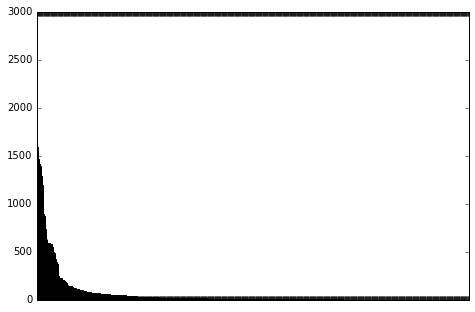

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Alpha value is
1.64095357463
Xmin value is
7.0
      properties                                         vocabulary
1077        7033  http://lov.okfn.org/dataset/lov/vocabs/dicom/v...
456         7033  http://lov.okfn.org/dataset/lov/vocabs/dicom/v...
621         2861  http://lov.okfn.org/dataset/lov/vocabs/dbpedia...
53          2795  http://lov.okfn.org/dataset/lov/vocabs/dbpedia...
288         1669  http://lov.okfn.org/dataset/lov/vocabs/lgdo/ve...
789         1336  http://lov.okfn.org/dataset/lov/vocabs/datex/v...
727          992  http://lov.okfn.org/dataset/lov/vocabs/schema/...
1060         976  http://lov.okfn.org/dataset/lov/vocabs/schema/...
421          965  http://lov.okfn.org/dataset/lov/vocabs/schema/...
1064         891  http://lov.okfn.org/dataset/lov/vocabs/schema/...
373          878  http://lov.okfn.org/dataset/lov/vocabs/schema/...
889          846  http://lov.okfn.org/dataset/lov/vocabs/schema/...
822          830  http://lov.okfn.org/dataset/lov/vocabs/schema/...
1

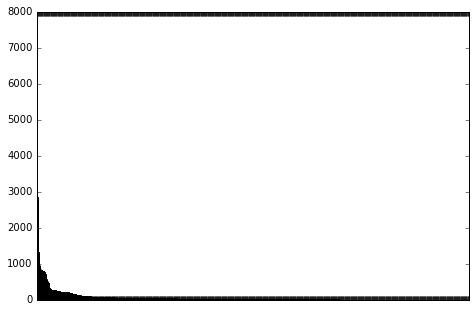

Alpha value is
2.00527011374
Xmin value is
34.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [9]:
print "----------------------------------------------------"
class_list=[]
vocs_list=[]
voaf = rdflib.Namespace("http://purl.org/vocommons/voaf#")
class_graph = rdflib.Graph()

class_graph += g.triples( (None, voaf.classNumber, None) )

for (s, p, o) in class_graph:
    vocs_list.append(str(s.encode('utf-8')))
    class_list.append(int(o))
class_df=pd.DataFrame({'vocabulary': vocs_list, 'classes': class_list})
print class_df.sort(['classes'], ascending=[0])
print class_df.sort(['classes'], ascending=[0])[['classes']].values.tolist()
class_list=sorted(class_list, reverse=True)
print "IQR classes" 
iqr=np.percentile(class_list, 75) - np.percentile(class_list, 25)
print iqr
print "----------------------------------------------------"
print "Histogram of classes"
plot_histogram(class_list)

import powerlaw
data = class_list
results = powerlaw.Fit(data)
print "Alpha value is"
print results.power_law.alpha
print "Xmin value is"
print results.power_law.xmin

prop_list=[]
vocs_list=[]
voaf = rdflib.Namespace("http://purl.org/vocommons/voaf#")
prop_graph = rdflib.Graph()

prop_graph += g.triples( (None, voaf.propertyNumber, None) )

for (s, p, o) in prop_graph:
    vocs_list.append(str(s.encode('utf-8')))
    prop_list.append(int(o))
prop_df=pd.DataFrame({'vocabulary': vocs_list, 'properties': prop_list})
print prop_df.sort(['properties'], ascending=[0])
print prop_df.sort(['properties'], ascending=[0])[['properties']].values.tolist()
prop_list=sorted(prop_list, reverse=True)
print "IQR properties" 
iqr=np.percentile(prop_list, 75) - np.percentile(prop_list, 25)
print iqr
print "----------------------------------------------------"
print "Histogram of properties"
plot_histogram(prop_list)

data = prop_list
results = powerlaw.Fit(data)
print "Alpha value is"
print results.power_law.alpha
print "Xmin value is"
print results.power_law.xmin

In [12]:
voc_space_list=[]
voc_space_graph = rdflib.Graph()
dcat = rdflib.Namespace("http://www.w3.org/ns/dcat#")

voc_space_graph += g.triples( (None, dcat.keyword, None) )

for (s, p, o) in voc_space_graph:
    voc_space_list.append(str(o))

print "----------------------------------------------------"
print "Use of vocabulary spaces"
print Counter(voc_space_list)
voc_spaces=[]

for voc_spac in Counter(voc_space_list):
    voc_spaces.append(Counter(voc_space_list)[voc_spac])

print "IQR VOC SPACES" 
iqr=np.percentile(voc_spaces, 75) - np.percentile(voc_spaces, 25)
print iqr
print "Third quartile"
print np.percentile(voc_spaces, 75) 
#print "Pie chart of vocabulary spaces"
#plot_cake_distribution(Counter(voc_space_list))

----------------------------------------------------
Use of vocabulary spaces
Counter({'Methods': 44, 'Metadata': 40, 'Catalogs': 34, 'Support': 30, 'API': 30, 'Geography': 30, 'Society': 28, 'RDF': 27, 'Quality': 26, 'Services': 23, 'People': 22, 'Industry': 20, 'Vocabularies': 20, 'Environment': 17, 'Time': 17, 'General & Upper': 17, 'IoT': 16, 'Events': 15, 'Multimedia': 14, 'Geometry': 14, 'FRBR': 14, 'Biology': 13, 'W3C Rec': 12, 'SPAR': 12, 'Government': 11, 'PLM': 11, 'Academy': 10, 'eBusiness': 9, 'Tag': 8, 'Travel': 8, 'Security': 8, 'Contracts': 7, 'Press': 7, 'Health': 7, 'Music': 6, 'Games': 6, 'Food': 6, 'SSDesk': 5, 'Image': 4, 'PROTON': 2, 'Rec': 2, 'CSV': 2})
IQR VOC SPACES
14.25
Third quartile
21.5


----------------------------------------------------
Use of VOAF properties in vocabularies
[('http://xmlns.com/foaf/0.1/', 6), ('http://lov.okfn.org/dataset/lov/vocabs/sam/versions/2014-08-28.n3', 6), ('http://purl.obolibrary.org/obo/obi.owl', 6), ('http://lov.okfn.org/dataset/lov/vocabs/tmo/versions/2012-07-03.n3', 6), ('http://www.w3.org/2002/07/owl', 6)]
Populating the interactive namespace from numpy and matplotlib


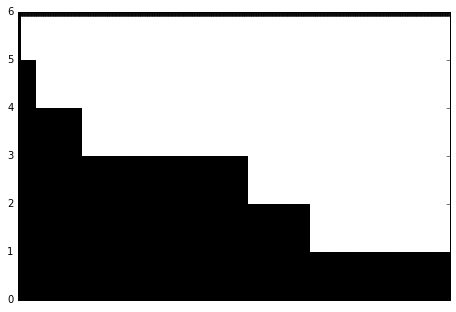

VOAF properties IQR
2.0


In [13]:
print "----------------------------------------------------"
print "Use of VOAF properties in vocabularies"
print Counter(datasets_list).most_common(5)
plot_histogram_counter(Counter(datasets_list))
datasets=[]
for dataset in Counter(datasets_list):
    datasets.append(Counter(datasets_list)[dataset])

iqr=np.percentile(datasets, 75) - np.percentile(datasets, 25)
print "VOAF properties IQR"
print iqr

#json_graph = sn.Sonnet(voc_graph)
#json_graph.jsonify()